In [7]:
# Cell 1: Import Libraries and Setup Paths
import cudf
import numpy as np
from cuml.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
processed_train_path = '/root/autodl-tmp/projects/SL_NSL/dataset/processed/multi/KDDTrain_processed.csv'
processed_test_path = '/root/autodl-tmp/projects/SL_NSL/dataset/processed/multi/KDDTest_processed.csv'

In [8]:
# Cell 2: Load and Preprocess Training Data
def load_and_preprocess_data(train_path, test_path, verbose=True):
    if verbose:
        print("Loading and preprocessing data...")
    
    # Load training and test data
    df_train = cudf.read_csv(train_path)
    df_test = cudf.read_csv(test_path)
    
    # Convert feature columns to float32
    feature_cols = [col for col in df_train.columns if col != 'multiclass_label']
    df_train[feature_cols] = df_train[feature_cols].astype('float32')
    df_test[feature_cols] = df_test[feature_cols].astype('float32')
    
    # Handle missing values
    df_train = df_train.fillna(df_train.mean())
    df_test = df_test.fillna(df_test.mean())
    
    # Split features and labels
    X_train = df_train[feature_cols]
    y_train = df_train['multiclass_label'].astype('int32')
    X_test = df_test[feature_cols]
    y_test = df_test['multiclass_label'].astype('int32')
    
    if verbose:
        print("Class distribution in training data:")
        print(y_train.value_counts().sort_index().to_pandas())
    
    return X_train, X_test, y_train, y_test

In [9]:
# Cell 3: Define Adaptive Sampling Function
def adaptive_sampling(X, y, verbose=False):
    X_cpu = X.to_pandas().values if isinstance(X, cudf.DataFrame) else X
    y_cpu = y.to_pandas().values if isinstance(y, cudf.Series) else y
    
    # Calculate class distributions
    class_counts = np.bincount(y_cpu)
    if verbose:
        print("Original class distribution:")
        print(class_counts)
    
    # Define sampling strategy
    sampling_strategy = {
        1: int(class_counts[1] * 1.05),  
        2: int(class_counts[2] * 1.2),   
        3: int(class_counts[3] * 2.0),   
        4: int(class_counts[4] * 3.0)    
    }
    
    # Apply SMOTE with adaptive strategy
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42,
        k_neighbors=min(5, min(class_counts[class_counts > 0]) - 1)
    )
    
    # Combine SMOTE with RandomUnderSampler
    under_sampler = RandomUnderSampler(sampling_strategy={0: int(class_counts[0] * 0.8)})
    pipeline = make_pipeline(smote, under_sampler)
    
    X_resampled, y_resampled = pipeline.fit_resample(X_cpu, y_cpu)
    
    if verbose:
        print("\nClass distribution after sampling:")
        print(np.bincount(y_resampled))
    
    return X_resampled, y_resampled

In [10]:
# Cell 4: Define Model Evaluation Function
def evaluate_model(model, X, y, dataset_name=""):
    print(f"\nEvaluating on {dataset_name}...")
    y_pred = model.predict(X)
    
    # Convert to correct types
    y = y.astype('int32')
    y_pred = cudf.Series(y_pred).astype('int32')
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    conf_mat = confusion_matrix(y, y_pred)
    
    # Calculate class-specific metrics
    y_cpu = y.to_pandas()
    y_pred_cpu = y_pred.to_pandas()
    class_report = classification_report(y_cpu, y_pred_cpu, zero_division=0)
    
    print(f"Accuracy: {accuracy:.3f}")
    print("\nConfusion Matrix:")
    print(conf_mat)
    print("\nClassification Report:")
    print(class_report)
    
    # Print prediction distribution
    print("\nPrediction distribution:")
    print(y_pred.value_counts().sort_index().to_pandas())
    print("\nTrue label distribution:")
    print(y.value_counts().sort_index().to_pandas())
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_mat,
        'classification_report': class_report
    }

In [11]:
def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, X_external, y_train, y_external = load_and_preprocess_data(
        processed_train_path, processed_test_path
    )
    
    # Split training data
    print("\nSplitting training data...")
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Feature selection
    print("\nPerforming feature selection...")
    selector = SelectKBest(f_classif, k=50)
    X_train_selected = selector.fit_transform(X_train_split.to_pandas(), y_train_split.to_pandas())
    X_val_selected = selector.transform(X_val.to_pandas())
    X_external_selected = selector.transform(X_external.to_pandas())
    
    # Balance training data
    print("\nBalancing training data...")
    X_train_balanced, y_train_balanced = adaptive_sampling(X_train_selected, y_train_split.to_pandas(), verbose=True)
    X_train_balanced = cudf.DataFrame(X_train_balanced)
    y_train_balanced = cudf.Series(y_train_balanced)
    
    # Create and train final model with Bagging
    print("\nTraining final model...")
    base_model = XGBClassifier(
        n_estimators=150,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=5,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=2,
        objective='multi:softmax',
        num_class=5,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
    
    # Use Bagging to improve model performance
    final_model = BaggingClassifier(
        estimator=base_model,
        n_estimators=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Train final model
    final_model.fit(X_train_balanced.to_pandas(), y_train_balanced.to_pandas())
    
    # Evaluate model
    val_metrics = evaluate_model(final_model, X_val_selected, y_val, "validation set")
    external_metrics = evaluate_model(final_model, X_external_selected, y_external, "external test set")
    
    
    # Visualize validation set confusion matrix
    print("\nGenerating validation set confusion matrix visualization...")
    plt.figure(figsize=(10, 8))
    
    # Convert CuPy array to NumPy if needed
    val_conf_matrix = val_metrics['confusion_matrix']
    if hasattr(val_conf_matrix, 'get'):
        val_conf_matrix_np = val_conf_matrix.get()
    else:
        val_conf_matrix_np = val_conf_matrix
    
    # Define class names
    class_names = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
    
    # Create heatmap
    sns.heatmap(val_conf_matrix_np, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Multi-class Confusion Matrix - Validation Set')
    plt.tight_layout()
    plt.savefig('multiclass_confusion_matrix_val.png')
    plt.show()
    
    # Visualize external test set confusion matrix
    print("\nGenerating external test set confusion matrix visualization...")
    plt.figure(figsize=(10, 8))
    
    # Convert CuPy array to NumPy if needed
    test_conf_matrix = external_metrics['confusion_matrix']
    if hasattr(test_conf_matrix, 'get'):
        test_conf_matrix_np = test_conf_matrix.get()
    else:
        test_conf_matrix_np = test_conf_matrix
    
    # Create heatmap
    sns.heatmap(test_conf_matrix_np, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Multi-class Confusion Matrix')
    plt.tight_layout()
    plt.savefig('multiclass_confusion_matrix_test.png')
    plt.show()
    
    # Create normalized version of external test set conf   usion matrix
    print("\nGenerating normalized confusion matrix...")
    plt.figure(figsize=(10, 8))
    
    # Normalize confusion matrix by row (true labels)
    row_sums = test_conf_matrix_np.sum(axis=1)
    test_conf_matrix_norm = test_conf_matrix_np / row_sums[:, np.newaxis]
    
    # Create normalized heatmap
    sns.heatmap(test_conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Normalized Confusion Matrix - External Test Set')
    plt.tight_layout()
    plt.savefig('multiclass_confusion_matrix_norm.png')
    plt.show()
    
    return final_model, val_metrics, external_metrics

Loading and preprocessing data...
Loading and preprocessing data...
Class distribution in training data:
0    67343
1    45927
2    11656
3      995
4       52
Name: multiclass_label, dtype: int64

Splitting training data...

Performing feature selection...

Balancing training data...
Original class distribution:
[53844 36806  9290   797    42]

Class distribution after sampling:
[43075 38646 11148  1594   126]

Training final model...

Evaluating on validation set...
Accuracy: 0.994

Confusion Matrix:
[[13448    12    23    16     0]
 [   11  9110     0     0     0]
 [   59     6  2301     0     0]
 [    9     0     0   189     0]
 [    7     0     0     0     3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13499
           1       1.00      1.00      1.00      9121
           2       0.99      0.97      0.98      2366
           3       0.92      0.95      0.94       198
           4       1.00      0.

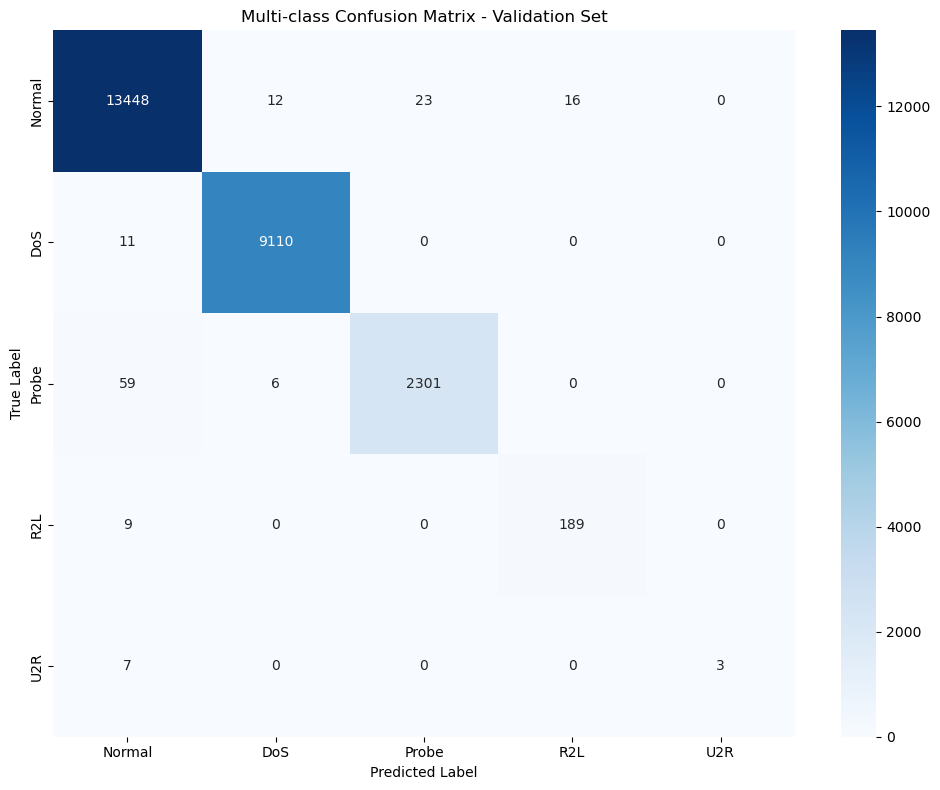


Generating external test set confusion matrix visualization...


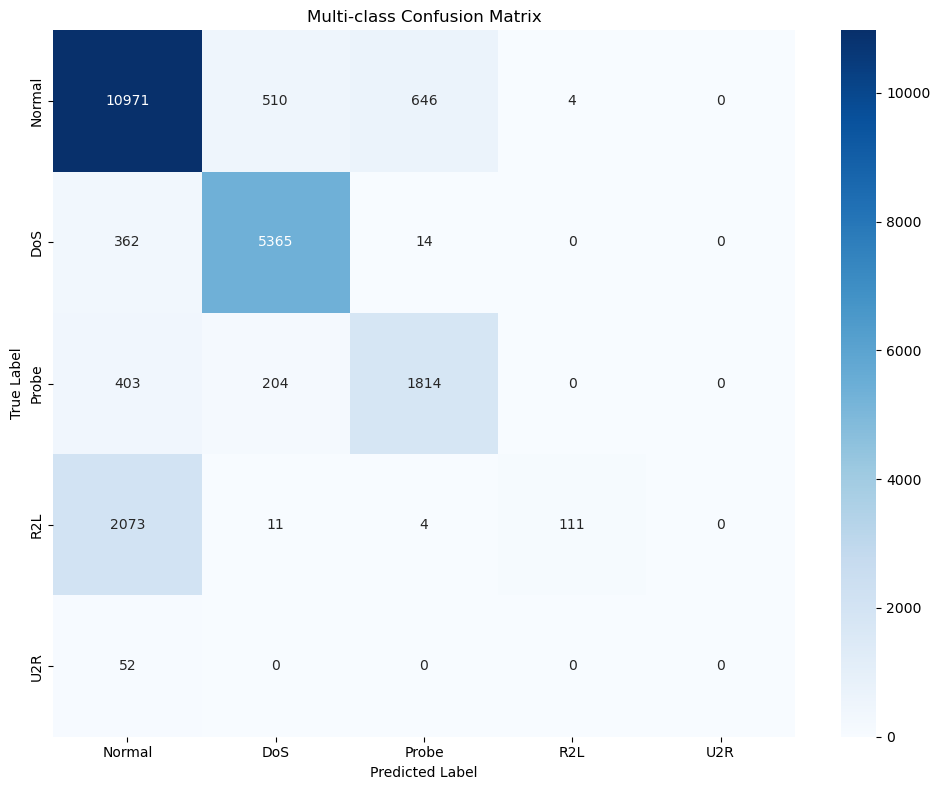


Generating normalized confusion matrix...


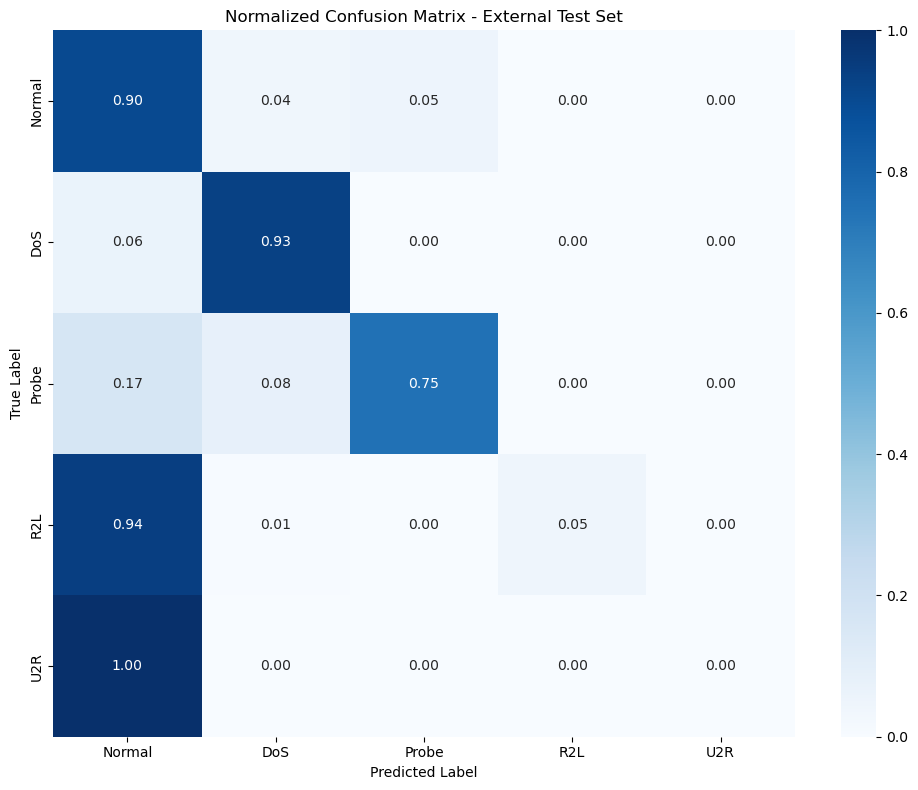

In [12]:
# Cell 6: Execute Main Function
if __name__ == "__main__":
    final_model, val_metrics, external_metrics = main()